## Binary classification on real-world data

***Implementation 3.1 Select a dataset from the libsvm repository. The dataset should have at least
20 features and 1,000 training samples.***

In [3]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.tr.bz2

--2022-02-27 08:51:50--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.tr.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 964465 (942K) [application/x-bzip2]
Saving to: ‘ijcnn1.tr.bz2.5’

ijcnn1.tr.bz2.5     100%[===================>] 941,86K   510KB/s    in 1,8s    

2022-02-27 08:51:54 (510 KB/s) - ‘ijcnn1.tr.bz2.5’ saved [964465/964465]



In [4]:
from joblib import Memory
import numpy as np
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data():
    data = load_svmlight_file("mushrooms")
    return data[0], data[1]

X, y = get_data()
X = X.A
# y = (y+1)/2

In [5]:
print("min y :",min(y))
print("max y :",max(y))
y = y-1

min y : 1.0
max y : 2.0


In [6]:
X.shape
import pandas as pd

print("Number of missing values in the whole dataset")
df = pd.DataFrame(X)
df.isnull().sum().sum()

Number of missing values in the whole dataset


0

In [7]:
m = X.shape[1]
n = X.shape[0]

for i in range(n):
    try:
        assert(not np.isnan(X[i,:].reshape(m,1)).any())
    except:
        print(X[i,:])

***Implementation 3.2 Given your dataset, implement the associated codes for g S , ∇g S and ∇ 2 g S ,
where S is a set of random indices in {1, . . . , n}***

Un terme de régularisation de norme L2 avec $\lambda = 0.0001$ a été ajouté

In [8]:
import torch
import numpy as np

# Le set S est accessible depuis l'intérieur de l'objet SubSampling Newton
def g_i(xi,yi,w,lambda_=0,debug=False):

    with open("./debug.log","a") as f:
        if debug:
            print("w in g_i",w,file=f)
            print("xi in g_i",xi,file=f)
            print("yi in g_i",yi,file=f)

    return ( yi - 1/(1+np.exp(-xi.T@w)) )**2 + 0.5*lambda_*np.linalg.norm(w)**2

def gradg_i(xi,yi,w,lambda_=0,debug=False):
    grad = xi
    grad *= -2*np.exp(xi.T@w) * (np.exp(xi.T@w)*(yi-1)+yi)/((1+np.exp(xi.T@w))**3)    
    grad += lambda_*w
    
    with open("./debug.log","a") as f:
        if debug:
            print("w in gradg_i",w,file=f)
            print("xi in gradg_i",xi,file=f)
            print("yi in gradg_i",yi,file=f)
            print("grad in gradg_i",grad,file=f)

    return grad

def Hg_i(xi,yi,w,lambda_=0,debug=False):
    m = w.shape[0]

    H = xi@xi.T
    H *= 2*np.exp(xi.T@w)*(np.exp(2*xi.T@w)*(yi-1)+2*np.exp(xi.T@w)-yi)
    H /= 1+np.exp(xi.T@w)**4
    H += lambda_*torch.eye(m,dtype=torch.float64)

    with open("./debug.log","a") as f:
        if debug:
            print("w in Hg_i",w,file=f)
            print("xi in Hg_i",xi,file=f)
            print("yi in Hg_i",yi,file=f)
            print("H in Hg_i",H,file=f)

    return H

### Subsampling Newton

In [9]:
import torch 
from torch.autograd.functional import hessian
from random import sample
from tqdm import tqdm


class SubsamplingNewton():
  """
  In subsampling Newton methods, we construct stochastic gradient and Hessian estimates from
  batches of data points, akin to a batch stochastic gradient approach.

  Inputs :
    X : Numerical features
    y : Target
    fi : Objective function at (xi,yi,w)
    gradf : Gradient of the objective wrt to w at (xi,yi,w)
    Hf : Hessian matrix at (xi,yi,w)
    step : choice of stepsize ["constant", "linesearch"]
  """
  def __init__(self,X,y,fi,gradf,Hf,step,lambda_=0,debug=False):
    self.fi = fi
    self.X = X
    self.y = torch.tensor(y,dtype=torch.float64) 
    self.gradf = gradf
    self.Hf = Hf
    self.n = X.shape[0]
    self.m = X.shape[1]
    self.step = step
    self.lambda_ = lambda_
    self.debug = debug
    assert(X.shape[0] == len(y))
    
  def get_Xrow(self,idx):
    xi = torch.tensor(self.X[idx,:],dtype=torch.float64).reshape(self.m,1) 
    assert(not np.isnan(xi).any())

    return xi

  def compute_gradient(self,w,Sk):  
    grad = torch.zeros_like(w,dtype=torch.float64)
    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      grad += self.gradf(xi,yi,w,self.lambda_,self.debug)
    grad /= len(Sk)
    return grad


  def compute_hessian(self,w,Sk):
    H = torch.zeros(self.m,self.m, dtype=torch.float64)
    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      H += self.Hf(xi,yi,w,self.lambda_,self.debug)
    H /= len(Sk) 
    return H

  def compute_direction(self,w,Sk,SkH):
    grad = self.compute_gradient(w,Sk)

    H = self.compute_hessian(w,SkH)  
    return  -torch.inverse(H) @ grad ,grad,H
    

  def linesearch(self,w,d,c,theta,grad,Sk):
        #Calcul du taux d'apprentissage avec une recherche linéaire
        fx = self.f_sk(w,Sk)
        alpha = 1        
        while self.f_sk(w+alpha*d,Sk) >  fx + c*alpha * d.T @ grad: 
          alpha *= theta   
        return alpha

  def f(self,w):
    y = 0
    for i in range(self.n):
      xi = self.get_Xrow(i)
      yi = self.y[i]
      y += self.fi(xi,yi,w,self.lambda_,self.debug)
    y /= self.n
    return y


  def f_sk(self,w,Sk):
    y = 0
    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      y += self.fi(xi,yi,w,self.lambda_,self.debug)
    y /= len(Sk)
    return y

  def run(self,w0,epsilon=1e-4, size_Sk=1,size_SkH=1,alpha0 = 0.001,
          nb_iterations = 50,convergence = "epsilon",
          c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []

      while True:        
        k += 1
        Sk = sample(range(self.n),size_Sk)
        SkH = sample(range(self.n),size_SkH)
        d,grad,_ = self.compute_direction(w,Sk,SkH)

        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        elif self.step == "Sk":
          m = len(w)
          X_temp = torch.zeros(m,m)

          for i in Sk:
            xi = self.get_Xrow(i)
            X_temp +=  xi @ xi.T          
          Lsk = 4*torch.norm(X_temp)/size_Sk + self.lambda_
          alpha = alpha0/Lsk
        else:
          alpha = alpha0


        w = w + alpha*d
        # print(self.f(w).detach().numpy())
        w_values.append(w)
        f_values.append(self.f(w))
        print("f= ", self.f(w))
        
        try:
          assert(not np.isnan(self.f(w)).any())
        except:
          print(grad)
          print(d)

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values

### Stochastic gradient (BGFS and LBGFS)

In [10]:
class BFGS_StochasticSecondOrderMethod(SubsamplingNewton): 
    def compute_direction(self,w,Hk,Sk):
      grad = self.compute_gradient(w,Sk)
      return  -Hk @ grad ,grad


    def run(self,w0,epsilon=1e-4, size_Sk=1,alpha0 = 0.01,nb_iterations = 200,convergence = "epsilon",
                    c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []

      Hk = torch.eye(self.m,dtype=torch.float64) 


      while True:        
        k += 1

        Sk = sample(range(n),size_Sk)
        d,grad = self.compute_direction(w,Hk,Sk)


        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        else:
          alpha = alpha0

        #update
        w_old = w
        w = w + alpha*d

        #compute Hk
        new_grad = self.compute_gradient(w,Sk)
        sk = w - w_old
        vk = new_grad - grad

        vk = vk.reshape(self.m,1)
        sk = sk.reshape(self.m,1)

        if sk.T @ vk > 0:
              M = (vk @ sk.T) / (sk.T @ vk)
              N = (sk @ sk.T) / (sk.T @ vk)
              A = torch.eye(self.m,dtype=torch.float64) - M
              Hk = A.T @ Hk @ A + N


        w_values.append(w.detach().numpy())
        f_values.append(self.f(w).detach().numpy()[0])

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values


class L_BFGS_StochasticSecondOrderMethod(BFGS_StochasticSecondOrderMethod): 
  def L_BFGS_update(self,memory_size,pairs,m):  
        if len(pairs) >= memory_size:
            l = max(0,memory_size-1)
        else:
            l = 0
        Hk = torch.eye(m,dtype=torch.float64)  

        for i in range(0,l):
          sk,vk = pairs[i]
          if sk.T @ vk > 0:
            M = (vk @ sk.T)/ (sk.T @ vk)
            N = (sk @ sk.T)/ (sk.T @ vk)
            A = torch.eye(m,dtype=torch.float64) - M
            Hk = A.T @ Hk @ A + N
            
                  
        return Hk


  def run(self,w0,epsilon=1e-4, size_Sk=1,memory_size = 5,alpha0 = 0.01,
              nb_iterations = 200,convergence = "epsilon",c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []
      pairs = []

      Hk = torch.eye(len(w0),dtype=torch.float64) 


      while True:        
        k += 1

        Sk = sample(range(self.n),size_Sk)
        d,grad = self.compute_direction(w,Hk,Sk)

        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        else:
          alpha = alpha0

        #update
        w_old = w
        w = w + alpha*d

        #compute Hk
        new_grad = self.compute_gradient(w,Sk)
        sk = w - w_old
        vk = new_grad - grad

        pairs.append((sk,vk))

        if len(pairs) > memory_size:
          pairs.pop(0)

        Hk = self.L_BFGS_update(memory_size,pairs,self.m)       


        w_values.append(w.detach().numpy())
        f_values.append(self.f(w).detach().numpy()[0])

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values

## Comparison of the algorithms

Question 3.1 Compare the performance of the subsampling Newton method from Section 2.1 and
that of the stochastic quasi-Newton method of Section 2.2 with a (batch) stochastic gradient ap-
proach. You may reuse the stochastic gradient implementation from the course notebooks.

In [11]:
lambda_ = 0.0001
SGSO = SubsamplingNewton(X,y,g_i,gradg_i,Hg_i,step = "constant",lambda_=lambda_,debug=False)

alpha_bar = 10
n = X.shape[0]
L = 4*np.linalg.norm(X @ X.T)/n + lambda_
alpha0 = alpha_bar/L

#initialisation aléatoire pour les poids w0
w0 = torch.rand(X.shape[1],dtype=torch.float64).reshape(X.shape[1],1)
w_values, f_values = SGSO.run(w0,
                              size_Sk=128,
                              size_SkH=128,
                              nb_iterations = 50,
                              alpha0 = alpha0,                              
                              convergence="epsilon",
                              c=0.0001,theta=0.5)


f=  tensor([[0.4838]], dtype=torch.float64)
tensor([[8.0268e-05],
        [5.4403e-05],
        [4.9864e-06],
        [7.9419e-05],
        [6.9476e-05],
        [1.7639e-05],
        [6.7430e-05],
        [6.6009e-05],
        [1.3835e-05],
        [3.5805e-05],
        [9.0757e-05],
        [7.2293e-05],
        [5.9147e-05],
        [1.4690e-05],
        [3.2492e-05],
        [4.5515e-05],
        [3.5381e-05],
        [1.5028e-05],
        [4.4021e-05],
        [6.0469e-05],
        [5.1211e-05],
        [9.7603e-05],
        [6.6357e-06],
        [7.9286e-05],
        [5.6271e-05],
        [3.8904e-05],
        [2.9605e-05],
        [4.4584e-05],
        [9.0354e-05],
        [8.0449e-05],
        [2.7933e-05],
        [6.0098e-05],
        [9.7143e-05],
        [1.0294e-04],
        [2.6866e-05],
        [2.5269e-05],
        [7.3934e-05],
        [9.1119e-06],
        [5.9331e-05],
        [2.7617e-05],
        [2.0649e-05],
        [7.1540e-05],
        [5.4030e-05],
        [2

In [ ]:
SGSO = BFGS_StochasticSecondOrderMethod(X_d,y,g_i,gradg_i,Hg_i,step = "constant")

alpha_bar = 0.001
n = X_d.shape[0]
lambda_ = 0.0001
L = 4*np.linalg.norm(X_d @ X_d.T)/n + lambda_
alpha0 = alpha_bar/L

w0 = torch.rand(X_d.shape[1],dtype=torch.float64).reshape(X_d.shape[1],1)
w_values, f_valuesBFGS_stoch = SGSO.run(w0,
                              size_Sk=128,
                              alpha0 = alpha0,
                              convergence="nb_iterations",
                              nb_iterations=50)

/tmp/ipykernel_942678/3371272164.py:11: RuntimeWarning: overflow encountered in exp
  grad = grad/(1+np.exp(xi.T@w)).data[0]**3 + 0.0001*w
/tmp/ipykernel_942678/3371272164.py:10: RuntimeWarning: overflow encountered in exp
  grad *= -(2*np.exp(xi.T@w) * (np.exp(xi.T@w)*(yi-1)+yi)).data[0]


Arrêt à 51 iterations


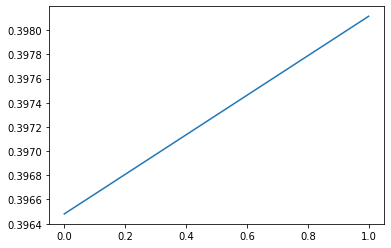

In [ ]:
plt.plot(f_valuesBFGS_stoch)

In [ ]:
SGSO = L_BFGS_StochasticSecondOrderMethod(X_d,y,g_i,gradg_i,Hg_i,step = "constant")


w0 = torch.rand(X_d.shape[1],dtype=torch.float64).reshape(X_d.shape[1],1)
w_values, f_valuesLBFGS_stoch = SGSO.run(w0,
                              size_Sk=32,
                              alpha0 = alpha0,
                              convergence="nb_iterations",
                              nb_iterations=100,
                              memory_size = 5)
print(w_values[-1])
print(f_values[-1])

/tmp/ipykernel_942678/4106527343.py:11: RuntimeWarning: overflow encountered in exp
  grad = grad/(1+np.exp(xi.T@w))**3 + 0.001*w
/tmp/ipykernel_942678/4106527343.py:10: RuntimeWarning: overflow encountered in exp
  grad *= -2*np.exp(xi.T@w) * (np.exp(xi.T@w)*(yi-1)+yi)


Arrêt à 101 iterations
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
tensor([[nan]], dtype=torch.float64)


## Extra credit (optional) : Choose a dataset with a testing set and compare the testing loss versus the training loss.

In [ ]:
import pandas as pd
df = pd.read_csv("space_ga.csv")
df.head()

df.binaryClass = df["binaryClass"].replace({"P":0,"N":1})

print("Nombre d'échantillons : ", len(df))
print("Nombre de variables (dont la cible) : ", len(df.columns))
print("-------------------------------------")
print("Nombre de valeurs manquantes dans chaque colonne:")
df.isna().sum()


Nombre d'échantillons :  3107
Nombre de variables (dont la cible) :  7
-------------------------------------
Nombre de valeurs manquantes dans chaque colonne:


ln(VOTES/POP)    0
POP              0
EDUCATION        0
HOUSES           0
INCOME           0
XCOORD           0
binaryClass      0
dtype: int64

In [ ]:
raw = df.to_numpy()
X = raw[:,:-1]
X = (X - X.mean())/(X.std())

y = raw[:,-1]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(2485, 6)

In [ ]:
SGSO = SubsamplingNewton(X_train,y_train,g_i,gradg_i,Hg_i,step = "constant")

alpha_bar = 0.001
n = X_train.shape[0]
lambda_ = 0.0001
L = 4*np.linalg.norm(X_train @ X_train.T)/n + lambda_
alpha0 = alpha_bar/L

#initialisation aléatoire pour les poids w0
w0 = torch.rand(X.shape[1],dtype=torch.float64).reshape(X.shape[1],1)
w_values, f_values = SGSO.run(w0,
                              size_Sk=32,
                              size_SkH=32,
                              nb_iterations = 100,
                              alpha0 = alpha0,                              
                              convergence="nb_iterations",
                              c=0.0001,theta=0.5)

/tmp/ipykernel_942678/566484312.py:11: RuntimeWarning: overflow encountered in exp
  grad = grad/(1+np.exp(xi.T@w))**3 + 0.0001*w
/tmp/ipykernel_942678/566484312.py:10: RuntimeWarning: overflow encountered in exp
  grad *= -2*np.exp(xi.T@w) * (np.exp(xi.T@w)*(yi-1)+yi)
/tmp/ipykernel_942678/566484312.py:18: RuntimeWarning: overflow encountered in exp
  H *= 2*np.exp(xi.T@w)*(np.exp(2*xi.T@w)*(yi-1)+2*np.exp(xi.T@w)-yi)
/tmp/ipykernel_942678/566484312.py:19: RuntimeWarning: overflow encountered in exp
  H /= (1+np.exp(xi.T@w))**4


Arrêt à 101 iterations


In [ ]:
f_values

[tensor([[0.3378]], dtype=torch.float64),
 tensor([[0.3500]], dtype=torch.float64),
 tensor([[0.3580]], dtype=torch.float64),
 tensor([[0.3518]], dtype=torch.float64),
 tensor([[0.3596]], dtype=torch.float64),
 tensor([[0.3695]], dtype=torch.float64),
 tensor([[0.3774]], dtype=torch.float64),
 tensor([[0.3868]], dtype=torch.float64),
 tensor([[0.4011]], dtype=torch.float64),
 tensor([[0.4075]], dtype=torch.float64),
 tensor([[0.4136]], dtype=torch.float64),
 tensor([[0.4280]], dtype=torch.float64),
 tensor([[0.4323]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=torch.float64),
 tensor([[nan]], dtype=to